A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing must have at least 3 coordinate tuples
A LinearRing

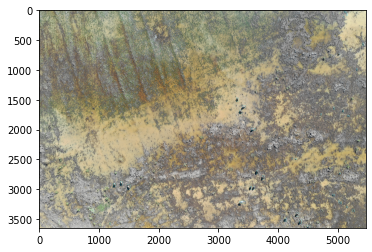

In [1]:
#Format newmexico
import pandas as pd
import re
import json
from shapely import geometry
import geopandas as gpd
from deepforest import visualize 
from matplotlib import pyplot as plt
import cv2

def get_filename(x):
    filename = re.search(pattern="-\w+.JPG", string=x).group()[1:]
    
    return filename

def create_box(x):
    try:
        pointList = [geometry.Point(node["x"],node["y"]) for node in x]
        minx, miny, maxx, maxy = geometry.Polygon([[p.x, p.y] for p in pointList]).bounds
        return geometry.box(minx, miny, maxx, maxy)
    except Exception as e:
        print(e)
        return None
    
df = pd.read_csv("/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/export-2019-11-21T21_33_07.694Z.csv")
df["image_path"] = df["Labeled Data"].apply(get_filename)

results = []
for index, row in df.iterrows():
    fname = get_filename(row["Labeled Data"])
    x = row["Label"]
    try:
        species_dict = json.loads(x)
    except:
        continue
    allboxes = []
    for x in species_dict:
        boxes = [box['geometry'] for box in species_dict[x]]
        geometries = [create_box(y) for y in boxes]
        for i in geometries:
            if i is not None:
                allboxes.append(i)
                
    row_df = pd.DataFrame({"geometry":allboxes})
    row_df["image_path"] = fname
    row_df["annotator"] = row["Created By"]
    results.append(row_df)

results = pd.concat(results)
gdf = gpd.GeoDataFrame(results)

merged_groups = []
for name, group in gdf.groupby("image_path"):
    merged_group = group[group.annotator == group["annotator"].value_counts().index[0]]
    merged_groups.append(merged_group)

merged_groups = pd.concat(merged_groups)
gdf = gpd.GeoDataFrame(merged_groups)
gdf = gdf[~(gdf.image_path == "BDA_24C_20181107_1.JPG")]
gdf.to_file("/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/shp/annotations.shp")
#sanity check
test_df = gdf[gdf.image_path == "BDA_18A4_20181107_2.JPG"].geometry.bounds
test_df = test_df.rename(columns={"minx":"xmin","miny":"ymin","maxx":"xmax","maxy":"ymax"})    
test_df["image_path"] = "BDA_18A4_20181107_2.JPG"
test_df["label"] = 0
img = cv2.imread("/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/USFWS/raw/BDA_18A4_20181107_2.JPG")
annotated = visualize.plot_predictions(img,test_df)
plt.imshow(annotated[:,:,::-1])